# Chapter 6 - Differentiating Intrinsic versus Post-hoc Explainability

[Local Interpretable Model-agnostic Explanations (LIME)](https://github.com/marcotcr/lime) is a popular local approximation and perturbation-based framework that provides post-hoc explanations for individual predictions. It performs perturbations on a local neighborhood of an instance to learn interpretable sparse linear models as explanations. LIME also provides qualitative explanations for a model’s prediction by highlighting relationships between an instance’s elements in textual and visual artifacts. This notebook provides an example of explaining predictions on image data using **LimeImageExplainer** and Inception V3 pre-trained model.

You can experiment with this example on [Amazon SageMaker Studio Lab](https://aws.amazon.com/sagemaker/studio-lab/), a free ML development environment that provides up to 12 hours of CPU or 4 hours of GPU per user session and 15 GiB storage at no cost. Alternatively, you can try this on your preferred Integrated Development Environment (IDE).

## Setup

In [2]:
import sys

!{sys.executable} -m pip install -qr requirements.txt

Keyring is skipped due to an exception: 'keyring.backends'


In [3]:
%matplotlib inline

from tensorflow import keras 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import inception_v3 as incv3
from tensorflow.keras.applications.imagenet_utils import decode_predictions

import tensorflow as tf
from skimage.io import imread
import os
import matplotlib.pyplot as plt
import numpy as np
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
from platform import python_version

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

print(f'TensorFlow version: {tf.__version__}')
print(f'Python version: {python_version()}')

TensorFlow version: 2.9.0
Python version: 3.7.10


## Load a Pre-trained Model

Use a Inception V3 pretrained model to make predictions. Default input image size of Inception-v3 is 299×299.

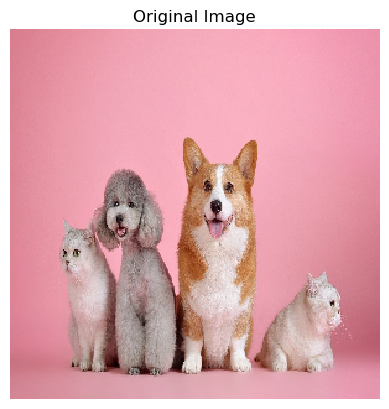

In [4]:
model = incv3.InceptionV3()

def load_process_img(path):
    images = []
    for img_path in path:
        img = image.load_img(img_path, target_size=(299, 299))
        m = image.img_to_array(img)
        m = np.expand_dims(m, axis=0)
        m = incv3.preprocess_input(m)
        images.append(m)
    return np.vstack(images)

images = load_process_img([os.path.join('./','pets.jpg')])

plt.imshow(images[0] / 2 + 0.5)
plt.axis('off')
plt.title("Original Image", fontsize=12)

plt.savefig('./original.png', bbox_inches='tight')

## Make Predictions

Obtain predictions for top 5 classes.

In [5]:
preds = model.predict(images)
print('Top 5 classes:')
for im in decode_predictions(preds)[0]:
    print(im)

1/1 [==============================] - 1s 1s/step
Top 5 classes:
('n02113023', 'Pembroke', 0.28453475)
('n02342885', 'hamster', 0.09641102)
('n04399382', 'teddy', 0.020572951)
('n02113186', 'Cardigan', 0.011049673)
('n02094258', 'Norwich_terrier', 0.010510642)


## Explain image classifiers

Use LimeImageExplainer to explaine an image classifier

In [6]:
# Explaining image classifiers

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(images[0], model.predict, top_labels=5, hide_color=0, num_samples=1000)

1/1 [==============================] - 1s 574ms/step



## Explain Top Classes

View superpixels that positively contributing to the class predictions with the rest of the image hidden.

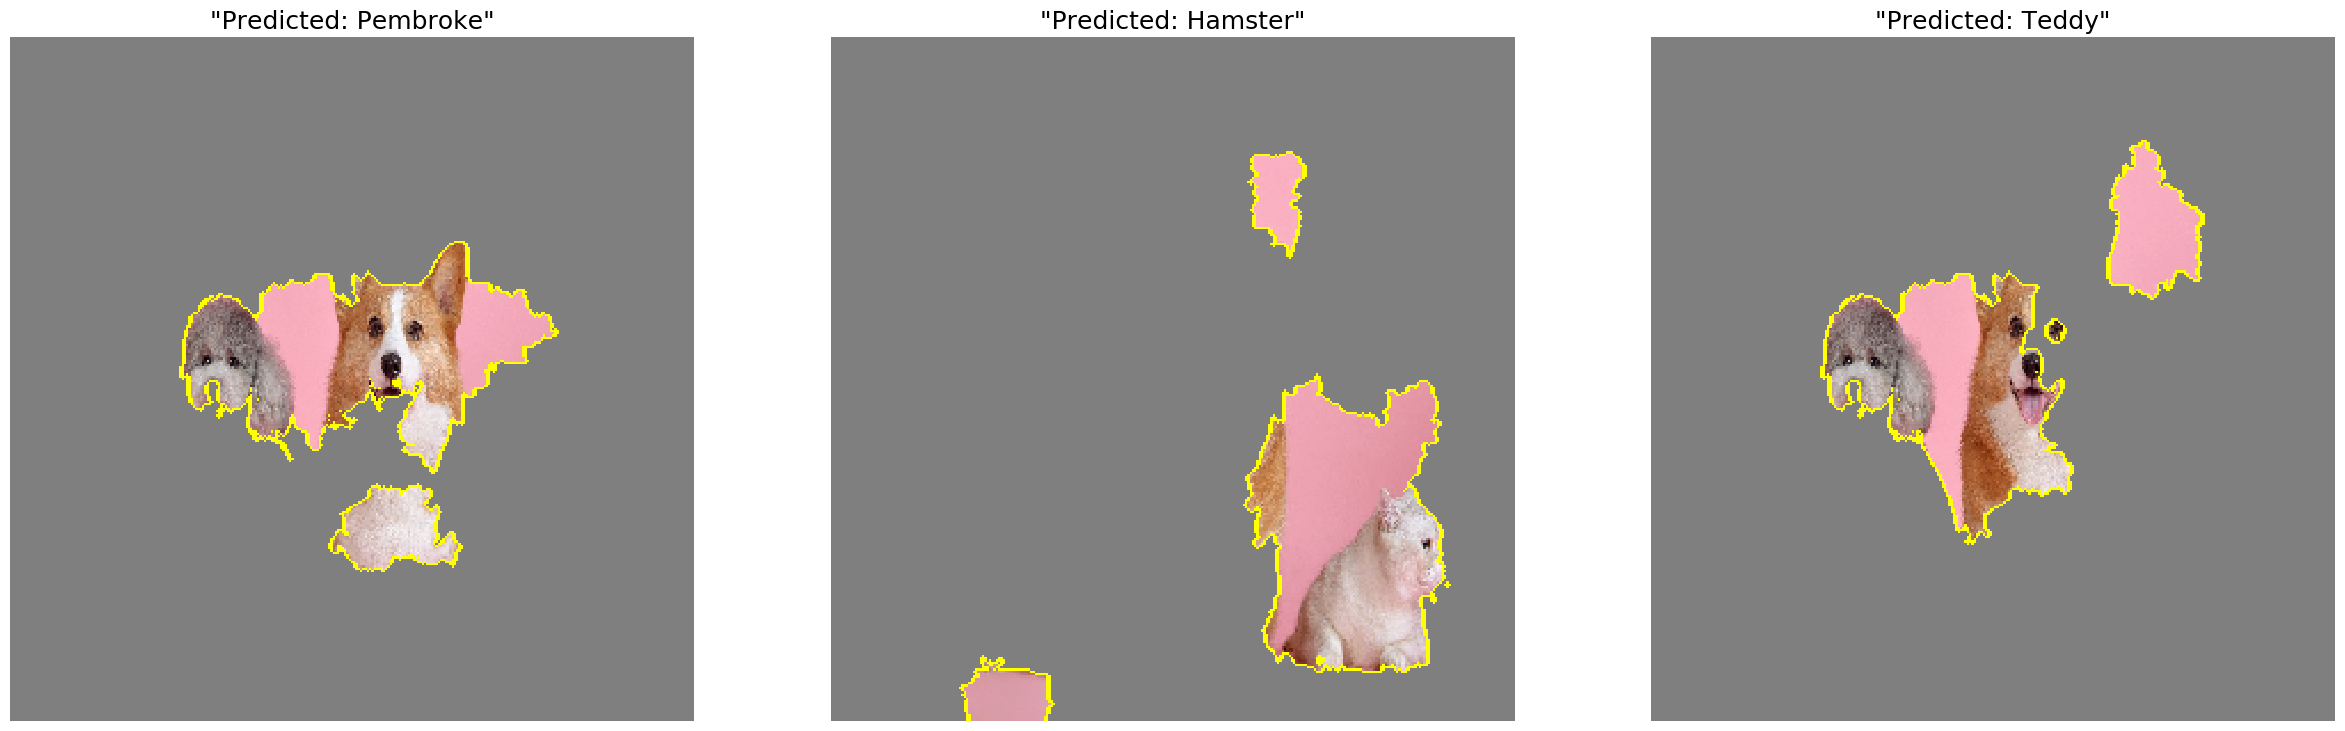

In [7]:
fig = plt.figure(figsize=(30, 30))

rows = 1
columns = 3

top3_classes = ['Pembroke', 'Hamster', 'Teddy']

for i in range(3):
    fig.add_subplot(rows, columns, i+1)
    tmp, mask = explanation.get_image_and_mask(explanation.top_labels[i], positive_only=True, num_features=5, hide_rest=True)
    plt.imshow(mark_boundaries(tmp / 2 + 0.5, mask))
    plt.axis('off')
    plt.title(f'"Predicted: {top3_classes[i]}"', fontsize=18)
    
plt.savefig('./topclass1.png', bbox_inches='tight')

View superpixels that positively contributing to the label predictions with the rest of the image present.

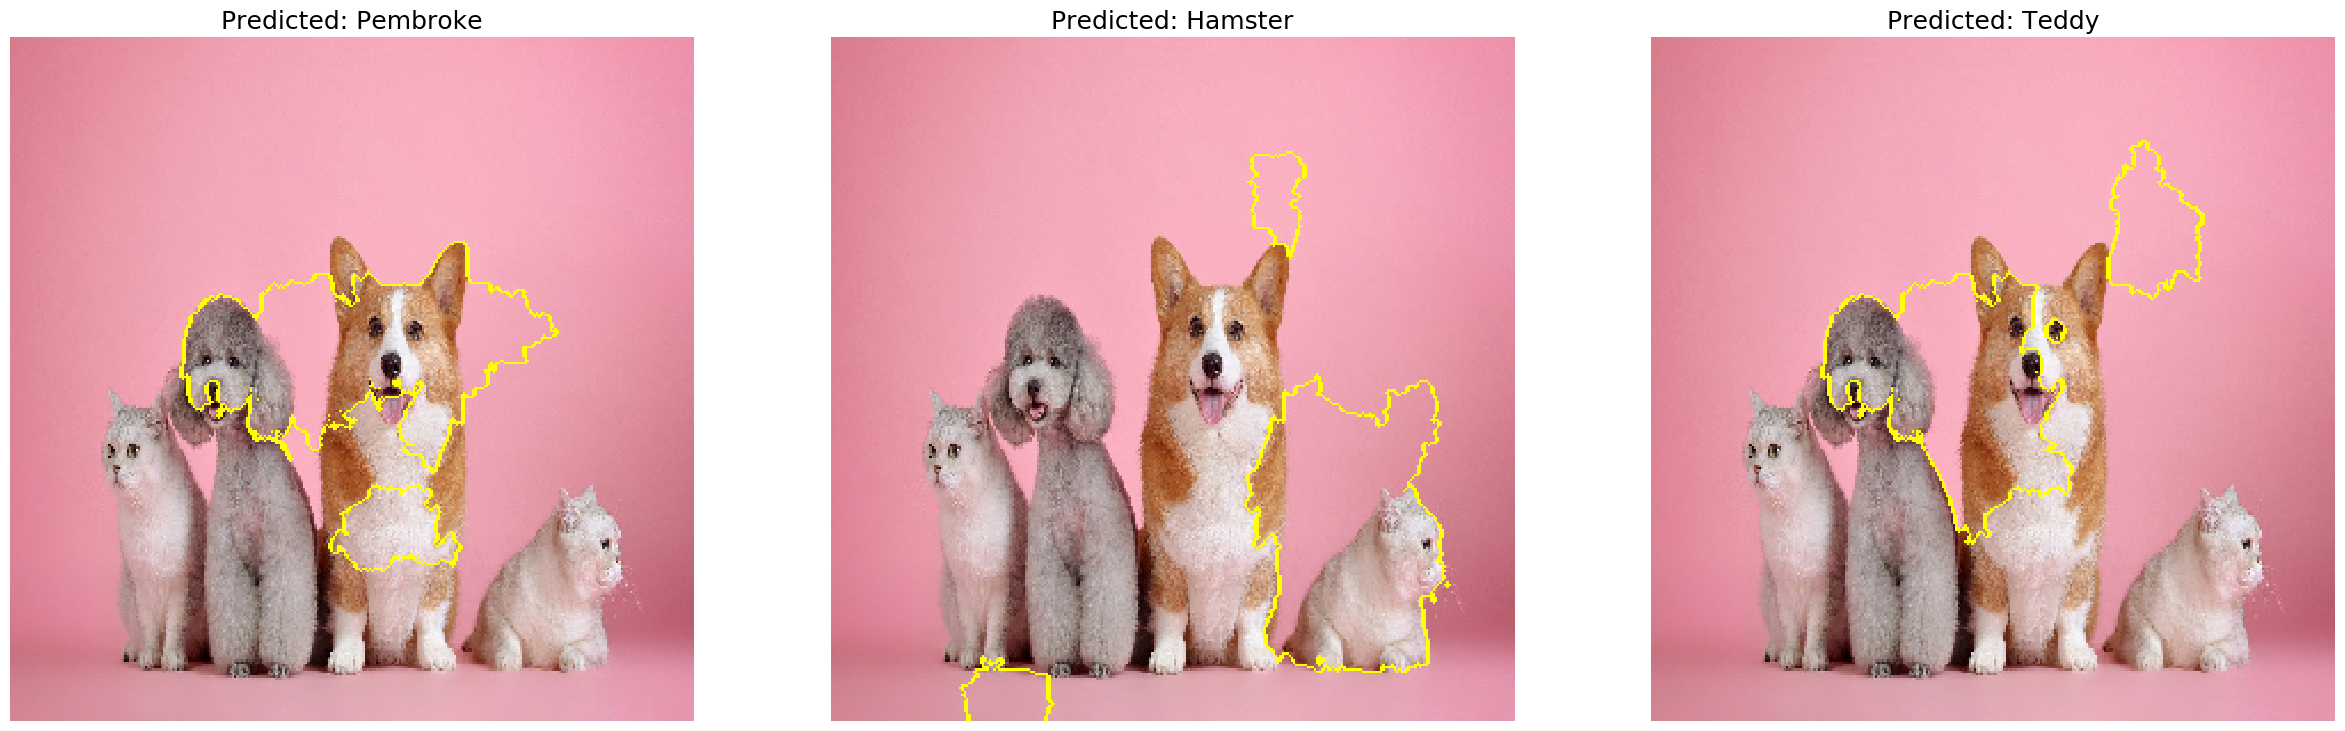

In [8]:
# Predicted classes are pembroke, hamster, teddy, cardigan, norwich_terrier

fig = plt.figure(figsize=(30, 30))
rows = 1
columns = 3

for i in range(3):
    fig.add_subplot(rows, columns, i+1)
    tmp, mask = explanation.get_image_and_mask(explanation.top_labels[i], positive_only=True, num_features=5, hide_rest=False)
    plt.imshow(mark_boundaries(tmp / 2 + 0.5, mask))
    plt.axis('off')
    plt.title(f'Predicted: {top3_classes[i]}', fontsize=18)

plt.savefig('./topclass2.png', bbox_inches='tight')

Superpixels that positively or negatively contribute to the label prediction. Positive in green, negative in red.

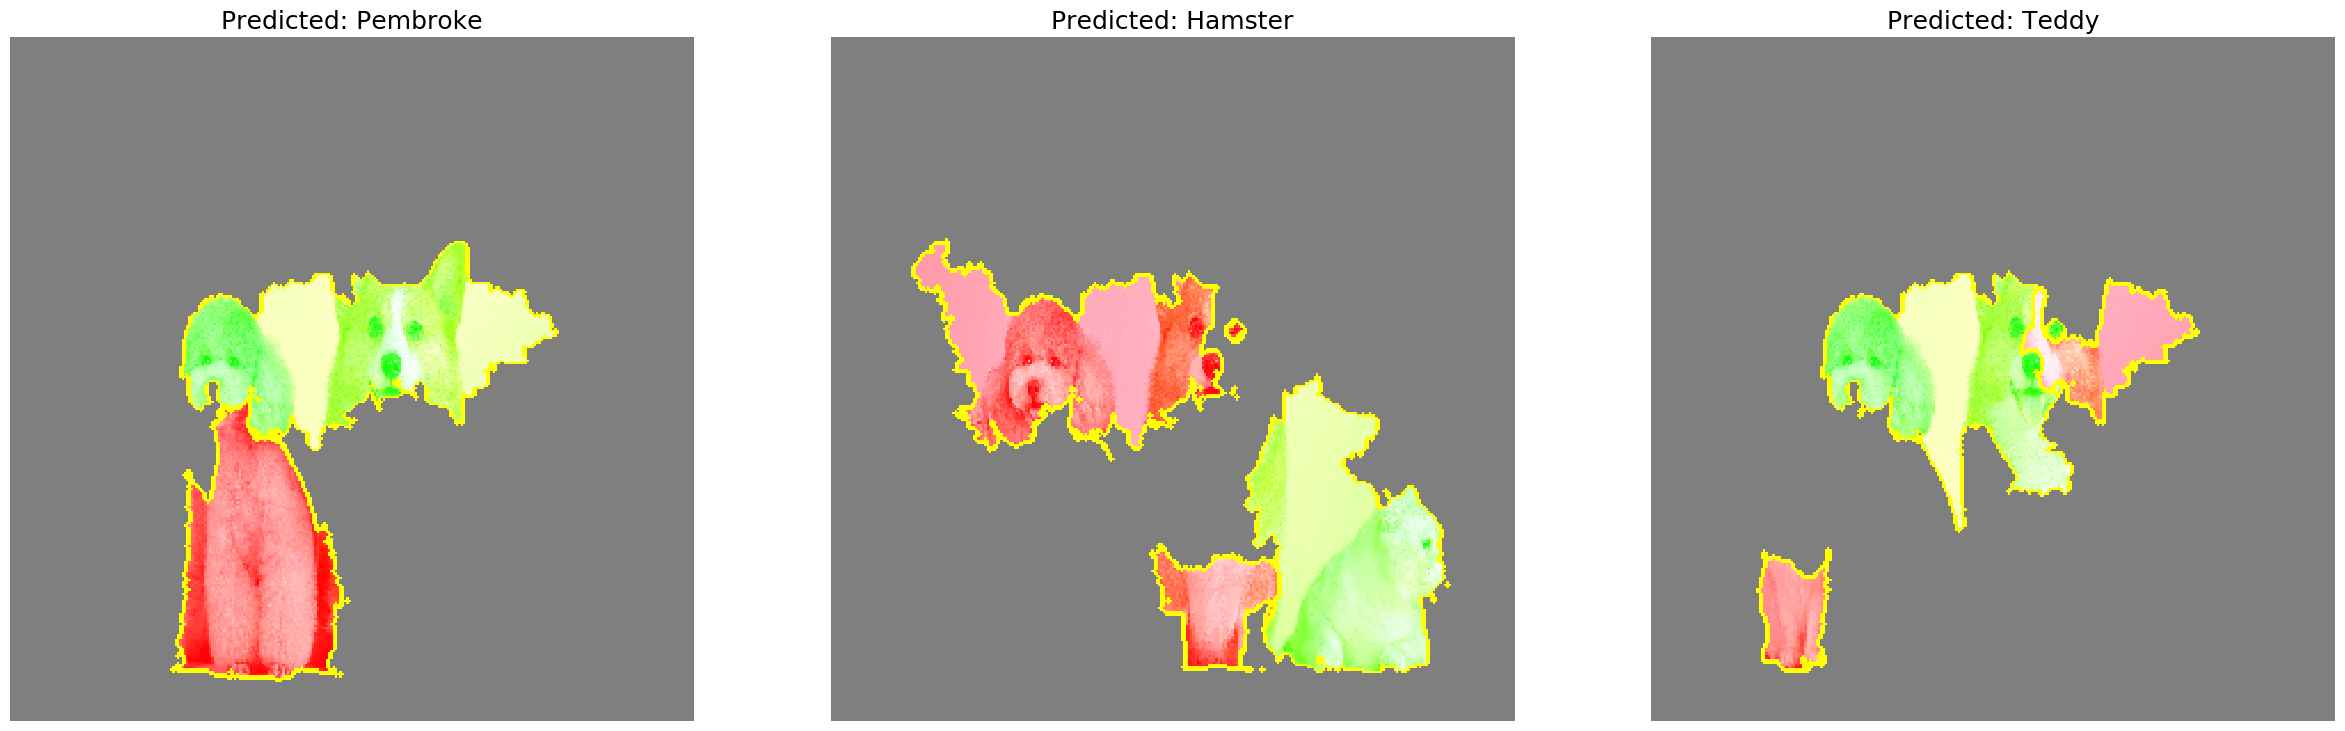

In [9]:
fig = plt.figure(figsize=(30, 30))
rows = 1
columns = 3

for i in range(3):
    fig.add_subplot(rows, columns, i+1)
    tmp, mask = explanation.get_image_and_mask(explanation.top_labels[i], positive_only=False, num_features=5, hide_rest=True)
    plt.imshow(mark_boundaries(tmp / 2 + 0.5, mask))
    plt.axis('off')
    plt.title(f'Predicted: {top3_classes[i]}', fontsize=18)


plt.savefig('./topclass3.png', bbox_inches='tight')

Explanation with minimum weight of the superpixels

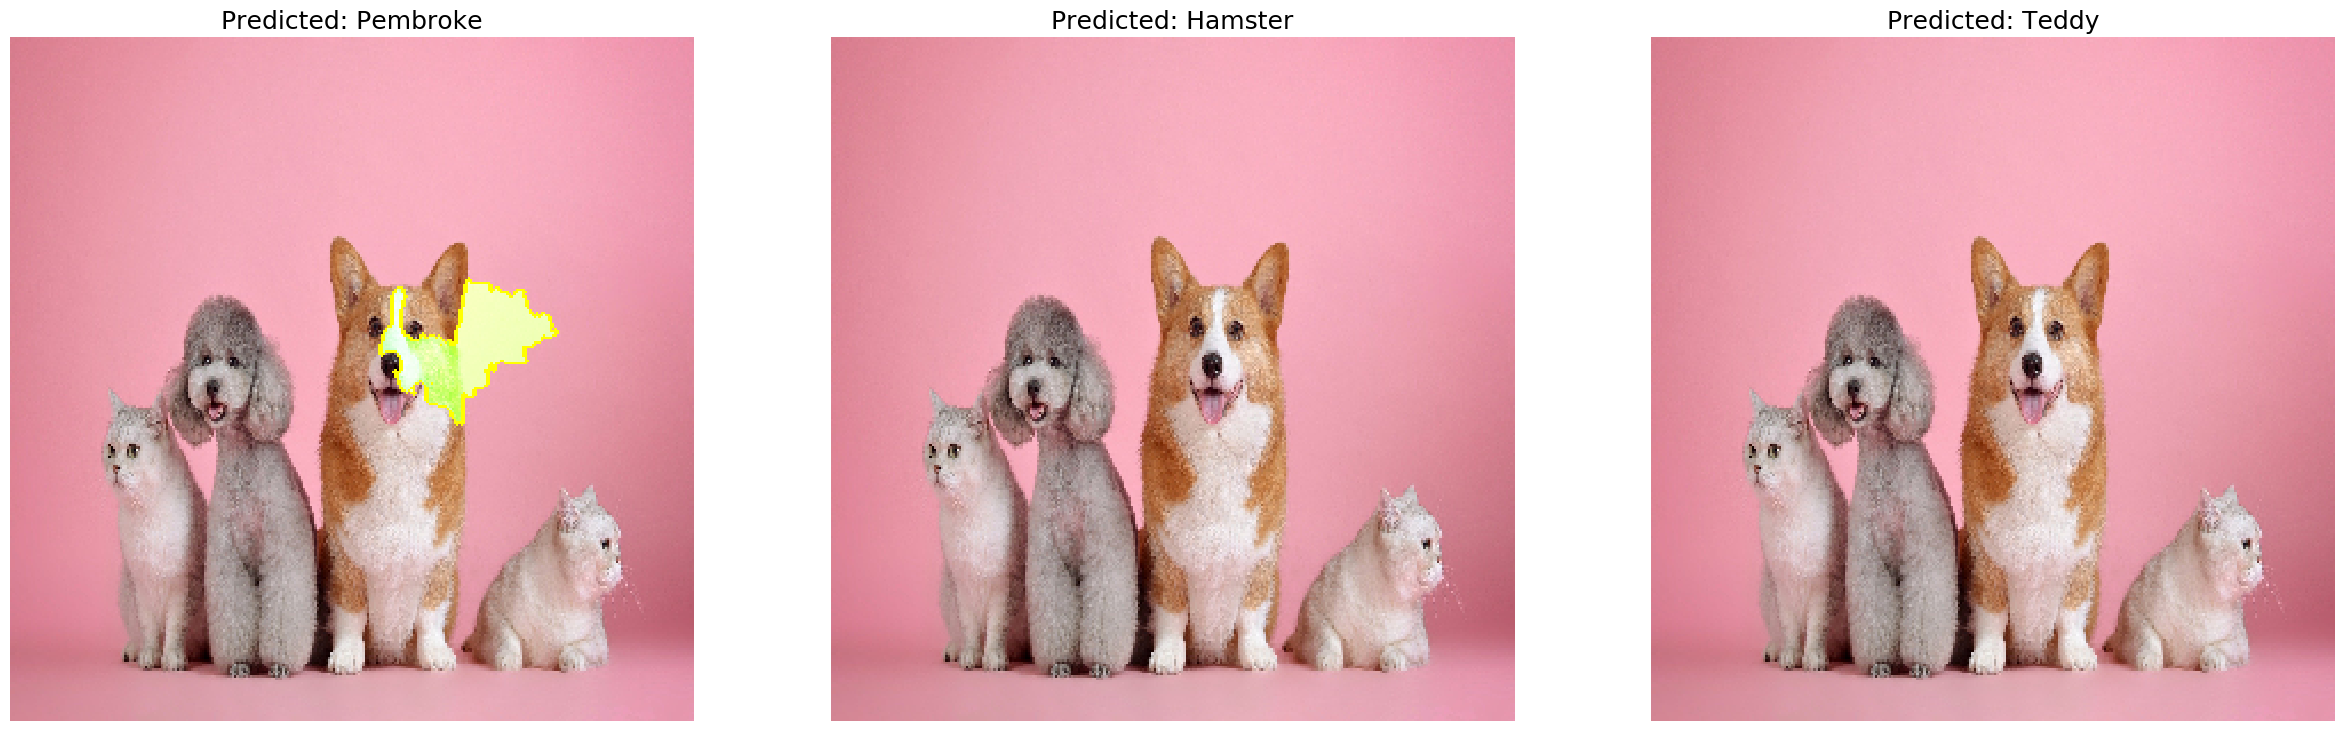

In [10]:
# Try adjust the min_weight to visualize the impact of superpixels to the model's explanations

fig = plt.figure(figsize=(30, 30))

rows = 1
columns = 3
min_weight = 0.1

for i in range(3):
    fig.add_subplot(rows, columns, i+1)
    tmp, mask = explanation.get_image_and_mask(explanation.top_labels[i], positive_only=False, num_features=5, hide_rest=False, min_weight=min_weight)
    plt.imshow(mark_boundaries(tmp / 2 + 0.5, mask))
    plt.axis('off')
    plt.title(f'Predicted: {top3_classes[i]}', fontsize=18)
    
plt.savefig('./min_weights.png', bbox_inches='tight')

This concludes the example walkthrough. You built an image classifier using Inception V3 pre-trained model and explained the output using LIME.